# Music venues and cost of living in most populous US cities

We will need a list of the most populous US cities, estimates for the cost of living of each, and information on music venue for each.

The first two tables of information we can grab from wikipedia. We can grab the last piece of information from the Foursquare API.

## Preliminary
Import necessary libraries, put in client ID and such

In [662]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import pickle
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium # plotting library
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import branca

geolocator = Nominatim(user_agent="foursquare_agent")

# input foursquare credentials
CLIENT_ID = 'FEKX35VA2NPKQUASN04CUPKIJHDKOE0Y5BZO2SFRLX24N22S' # your Foursquare ID
CLIENT_SECRET = 'BYY5BWEJ45S4ZYZNCO5HTVWU2W2S5GJEOKID2JVW1HQ01RQ3' # your Foursquare Secret
VERSION = '20180604'

## Populate and clean data
At end of this section have dataframe df_0, which has all relevant data other than latitude and longitude of all of the venues returned (up to 200) in each relevant city. This venue latitude and longitude data is populated in lists lat_lon_comedy, lat_lon_music, and lat_lon_performing.

In [370]:
# Tables read from Wikipedia will have references, of the form '[*]'. Function below removes these.
def remove_references(str_1):
    ref_ind = str_1.find('[')
    if ref_ind != -1:
        return str_1[:ref_ind]
    else:
        return str_1

In [429]:
# Populate df_1 : US cities by population

data_1 = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population')
df_1 = data_1[4]
df_1.columns = [\
                '2019 rank',                       'city',                            \
                'state',                           '2019 estimate',                   \
                '2010 census',                     'change',                          \
                '2016 land area (mi^2)',           '2016 land area (km^2)',           \
                '2016 population density (mi^-2)', '2016 population density (km^-2)', \
                'Location'                                                            \
               ]
df_1 = df_1[1:]

for i in range(len(df_1)):
    df_1.iloc[i]['city'] = remove_references(df_1.iloc[i]['city'])
df_1

2019 rank            city                 state 2019 estimate 2010 census  \
1           1   New York City              New York       8336817     8175133   
2           2     Los Angeles            California       3979576     3792621   
3           3         Chicago              Illinois       2693976     2695598   
4           4         Houston                 Texas       2320268     2100263   
5           5         Phoenix               Arizona       1680992     1445632   
6           6    Philadelphia          Pennsylvania       1584064     1526006   
7           7     San Antonio                 Texas       1547253     1327407   
8           8       San Diego            California       1423851     1307402   
9           9          Dallas                 Texas       1343573     1197816   
10         10        San Jose            California       1021795      945942   
11         11          Austin                 Texas        978908      790390   
12         12    Jacksonville               Florida        911507      821784   
13         13      Fort Worth                 Texas        909585      741206   
14         14        Columbus                  Ohio        898553      787033   
15         15       Charlotte        North Carolina        885708      731424   
16         16   San Francisco            California        881549      805235   
17         17    Indianapolis               Indiana        876384      820445   
18         18         Seattle            Washington        753675      608660   
19         19          Denver              Colorado        727211      600158   
20         20      Washington  District of Columbia        705749      601723   
21         21          Boston         Massachusetts        692600      617594   
22         22         El Paso                 Texas        681728      649121   
23         23       Nashville             Tennessee        670820      601222   
24         24         Detroit              Michigan        670031      713777   
25         25   Oklahoma City              Oklahoma        655057      579999   
26         26        Portland                Oregon        654741      583776   
27         27       Las Vegas                Nevada        651319      583756   
28         28         Memphis             Tennessee        651073      646889   
29         29      Louisville              Kentucky        617638      597337   
30         30       Baltimore              Maryland        593490      620961   
..        ...             ...                   ...           ...         ...   
288       288           Tyler                 Texas        106985       96900   
289       289           Davie               Florida        106306       91992   
290       290        Lakewood            New Jersey        106300       92843   
291       291       Daly City            California        106280      101123   
292       292         Boulder              Colorado        105673       97385   
293       293           Allen                 Texas        105623       84246   
294       294     West Covina            California        105101      106098   
295       295          Sparks                Nevada        105006       90264   
296       296   Wichita Falls                 Texas        104683      104553   
297       297       Green Bay             Wisconsin        104578      104057   
298       298       San Mateo            California        104430       97207   
299       299         Norwalk            California        103949      105549   
300       300          Rialto            California        103526       99171   
301       301      Las Cruces            New Mexico        103432       97618   
302       302           Chico            California        103301       86187   
303       303        El Cajon            California        102708       99478   
304       304         Burbank            California        102511      103340   
305       305      South Bend      

In [430]:
# Populate df_2 : US cities by cost of living

# Cost of living data from : https://advisorsmith.com/data/coli/ , chosen because it was an early Google result and is free.
# Up-to-date as of 2020-06-05. Uses linear model with weights:
#     Food: 16.1%
#     Housing: 23.2%
#     Utilities: 10.1%
#     Transportation: 18.6%
#     Healthcare: 9.6%
#     Consumer Discretionary Spending: 22.3%

df_2 = pd.read_csv('advisorsmith_cost_of_living_index.csv')
df_2['City'].loc[df_2['City'] == 'New York'] = 'New York City' # One manual change, based on quick glance at data table
df_2 = df_2.rename(columns={'City' : 'city', 'State' : 'state abbreviation'}) # rename columns for later merging

# only use of df_states will be to provide df_2 with state column, for later merging with df_1
df_states = pd.read_csv('us_state_names_and_abbreviations.csv')
df_states.columns = ['state', 'state abbreviation']

df_2 = pd.merge(df_2, df_states, how='inner', on='state abbreviation')

df_2.head()

C:\Users\Spencer\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


city state abbreviation  Cost of Living Index       state
0    Aberdeen                 WA                  95.5  Washington
1  Bellingham                 WA                 112.0  Washington
2   Bremerton                 WA                 115.4  Washington
3   Centralia                 WA                 101.8  Washington
4   Kennewick                 WA                 101.7  Washington

In [431]:
# df_0 will be fully merged dataframe

df_0 = pd.merge(df_1, df_2, how='inner', on=['city', 'state'])

# rearrange columns to be more to my liking
cols = list(df_0.columns)
cols = cols[0:3] + cols[11:] + cols[3:11]
df_0 = df_0[cols]
df_0['2019 rank'] = df_0['2019 rank'].astype('int')
df_0 = df_0.sort_values(by='2019 rank')

# More finite version of the merged df
df_0_top_50 = df_0.ix[:50-1, df_0.columns]

print(len(df_0))
print(len(df_0_top_50))
df_0.head()

C:\Users\Spencer\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


158
50


2019 rank           city       state state abbreviation  \
0          1  New York City    New York                 NY   
1          2    Los Angeles  California                 CA   
2          3        Chicago    Illinois                 IL   
3          4        Houston       Texas                 TX   
4          5        Phoenix     Arizona                 AZ   

   Cost of Living Index 2019 estimate 2010 census   change  \
0                 131.0       8336817     8175133   +1.98%   
1                 143.4       3979576     3792621   +4.93%   
2                 102.0       2693976     2695598   −0.06%   
3                  96.9       2320268     2100263  +10.48%   
4                 105.8       1680992     1445632  +16.28%   

  2016 land area (mi^2) 2016 land area (km^2) 2016 population density (mi^-2)  \
0           301.5 sq mi             780.9 km2                    28,317/sq mi   
1           468.7 sq mi           1,213.9 km2                     8,484/sq mi   
2           227.3 sq mi             588.7 km2                    11,900/sq mi   
3           637.5 sq mi           1,651.1 km2                     3,613/sq mi   
4           517.6 sq mi           1,340.6 km2                     3,120/sq mi   

  2016 population density (km^-2)  \
0                      10,933/km2   
1                       3,276/km2   
2                       4,600/km2   
3                       1,395/km2   
4                       1,200/km2   

                                            Location  
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...  
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...  
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...  
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...  
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...

In [432]:
results_list_comedy     = [item for item in range(len(df_0))]
results_list_music      = [item for item in range(len(df_0))]
results_list_performing = [item for item in range(len(df_0))]

In [375]:
# Below code commented out after first time running, since don't want to rerun
# all of the same queries every time the notebook is run. Saved the results as data files instead.

for i in range(len(results_list_comedy)):#range(33, len(results_list_comedy)):# range(len(results_list_comedy)):
    try:
        city_name  = df_0['city'][i]
        state_abbr = df_0['state abbreviation'][i]
        address = city_name + ', ' + state_abbr

        location   = geolocator.geocode(address)
        latitude   = location.latitude
        longitude  = location.longitude
        # https://developer.foursquare.com/docs/build-with-foursquare/categories/
        search_query_comedy     = 'Comedy Club'
        category_id_comedy      = '4bf58dd8d48988d18e941735'
        search_query_music      = 'Music Venue'
        category_id_music       = '4bf58dd8d48988d1e5931735'
        search_query_performing = 'Performing Arts Venue'
        category_id_performing  = '4bf58dd8d48988d1f2931735'
        # radius       = 100000
        radius       = 15000
        limit        = 200
        offset = 0

        url_comedy     = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&offset={}'\
        .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_id_comedy,     radius, limit, offset)
        url_music      = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&offset={}'\
        .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_id_music,      radius, limit, offset)
        url_performing = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&offset={}'\
        .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_id_performing, radius, limit, offset)

        results_comedy     = requests.get(url_comedy).json()
        results_music      = requests.get(url_music).json()
        results_performing = requests.get(url_performing).json()

        results_list_comedy[i]     = results_comedy
        results_list_music[i]      = results_music
        results_list_performing[i] = results_performing
    except:
        print(i)
        continue

In [376]:
# don't want to have to use the foursquare api every time this is loaded. Save above lists.
with open('results_list_comedy.data',     'wb') as filehandle:
    pickle.dump(results_list_comedy,     filehandle)
with open('results_list_music.data',      'wb') as filehandle:
    pickle.dump(results_list_music,      filehandle)
with open('results_list_performing.data', 'wb') as filehandle:
    pickle.dump(results_list_performing, filehandle)

# or, if they already exist, can read them in, see below:

In [433]:
with open('results_lists/results_list_comedy_15km.data',     'rb') as filehandle:
    results_list_comedy     = pickle.load(filehandle)
with open('results_lists/results_list_music_15km.data',      'rb') as filehandle:
    results_list_music      = pickle.load(filehandle)
with open('results_lists/results_list_performing_15km.data', 'rb') as filehandle:
    results_list_performing = pickle.load(filehandle)

In [434]:
total_results_comedy     = [0 for item in range(len(results_list_comedy))]
total_results_music      = [0 for item in range(len(results_list_music))]
total_results_performing = [0 for item in range(len(results_list_performing))]
for i in range(len(total_results_comedy)):
    
    if type(results_list_comedy[i]) == dict:
        if len(results_list_comedy[i]['response']) > 0 and len(results_list_comedy[i]['response']['groups'][0]['items']) > 0:
            total_results_comedy[i] = results_list_comedy[i]['response']['totalResults']
        else:
            total_results_comedy[i] = -1
    else:
        total_results_comedy[i] = -1
    
    if type(results_list_music[i]) == dict:
        if len(results_list_music[i]['response']) > 0 and len(results_list_music[i]['response']['groups'][0]['items']) > 0:
            total_results_music[i] = results_list_music[i]['response']['totalResults']
        else:
            total_results_music[i] = -1
    else:
        total_results_music[i] = -1
    
    if type(results_list_performing[i]) == dict:
        if len(results_list_performing[i]['response']) > 0 and len(results_list_performing[i]['response']['groups'][0]['items']) > 0:
            total_results_performing[i] = results_list_performing[i]['response']['totalResults']
        else:
            total_results_performing[i] = -1
    else:
        total_results_performing[i] = -1


In [435]:
df_3 = pd.DataFrame(np.transpose([total_results_comedy, total_results_music, total_results_performing]), \
                   columns=['total results - comedy', 'total results - music', 'total results - performing'])

df_0 = pd.merge(df_0, df_3, left_index=True, right_index=True)

In [436]:
lat_lon_comedy     = [0 for item in range(len(results_list_comedy))]
lat_lon_music      = [0 for item in range(len(results_list_music))]
lat_lon_performing = [0 for item in range(len(results_list_performing))]
for i in range(len(lat_lon_comedy)):
    
    results_available = -1
    if type(results_list_comedy[i]) == dict:
        if len(results_list_comedy[i]['response']) > 0 and len(results_list_comedy[i]['response']['groups'][0]['items']) > 0:
            results_available = len(results_list_comedy[i]['response']['groups'][0]['items'])
            lat_lon_comedy[i] = [[0, 0] for item in range(results_available)]
            for j in range(results_available):
                lat = results_list_performing[i]['response']['groups'][0]['items'][j]['venue']['location']['lat']
                lng = results_list_performing[i]['response']['groups'][0]['items'][j]['venue']['location']['lng']
                lat_lon_comedy[i][j] = [lat, lng]
        else:
            lat_lon_comedy[i] = -1
    else:
        lat_lon_comedy[i] = -1
    
    results_available = -1
    if type(results_list_music[i]) == dict:
        if len(results_list_music[i]['response']) > 0 and len(results_list_music[i]['response']['groups'][0]['items']) > 0:
            results_available = len(results_list_music[i]['response']['groups'][0]['items'])
            lat_lon_music[i] = [[0, 0] for item in range(results_available)]
            for j in range(results_available):
                lat = results_list_music[i]['response']['groups'][0]['items'][j]['venue']['location']['lat']
                lng = results_list_music[i]['response']['groups'][0]['items'][j]['venue']['location']['lng']
                lat_lon_music[i][j] = [lat, lng]
        else:
            lat_lon_music[i] = -1
    else:
        lat_lon_music[i] = -1
    
    results_available = -1
    if type(results_list_performing[i]) == dict:
        if len(results_list_performing[i]['response']) > 0 and len(results_list_performing[i]['response']['groups'][0]['items']) > 0:
            results_available = len(results_list_performing[i]['response']['groups'][0]['items'])
            lat_lon_performing[i] = [[0, 0] for item in range(results_available)]
            for j in range(results_available):
                lat = results_list_performing[i]['response']['groups'][0]['items'][j]['venue']['location']['lat']
                lng = results_list_performing[i]['response']['groups'][0]['items'][j]['venue']['location']['lng']
                lat_lon_performing[i][j] = [lat, lng]
        else:
            lat_lon_performing[i] = -1
    else:
        lat_lon_performing[i] = -1


In [438]:
df_0.head()

2019 rank           city       state state abbreviation  \
0          1  New York City    New York                 NY   
1          2    Los Angeles  California                 CA   
2          3        Chicago    Illinois                 IL   
3          4        Houston       Texas                 TX   
4          5        Phoenix     Arizona                 AZ   

   Cost of Living Index 2019 estimate 2010 census   change  \
0                 131.0       8336817     8175133   +1.98%   
1                 143.4       3979576     3792621   +4.93%   
2                 102.0       2693976     2695598   −0.06%   
3                  96.9       2320268     2100263  +10.48%   
4                 105.8       1680992     1445632  +16.28%   

  2016 land area (mi^2) 2016 land area (km^2) 2016 population density (mi^-2)  \
0           301.5 sq mi             780.9 km2                    28,317/sq mi   
1           468.7 sq mi           1,213.9 km2                     8,484/sq mi   
2           227.3 sq mi             588.7 km2                    11,900/sq mi   
3           637.5 sq mi           1,651.1 km2                     3,613/sq mi   
4           517.6 sq mi           1,340.6 km2                     3,120/sq mi   

  2016 population density (km^-2)  \
0                      10,933/km2   
1                       3,276/km2   
2                       4,600/km2   
3                       1,395/km2   
4                       1,200/km2   

                                            Location  total results - comedy  \
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...                     141   
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...                     138   
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...                      86   
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...                      21   
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...                      32   

   total results - music  total results - performing  
0                    289                         231  
1                    186                         168  
2                    201                         182  
3                    150                         160  
4                    137                         152

In [441]:
# last step : remove the entries in the lists and data frames for which no results were found.

removal_indices = []
removal_indices = removal_indices + df_0.loc[df_0['total results - comedy'] == -1].index.tolist()
removal_indices = removal_indices + df_0.loc[df_0['total results - music'] == -1].index.tolist()
removal_indices = removal_indices + df_0.loc[df_0['total results - performing'] == -1].index.tolist()

removal_indices = removal_indices + [lat_lon_comedy.index(-1)]
removal_indices = removal_indices + [lat_lon_music.index(-1)]
removal_indices = removal_indices + [lat_lon_performing.index(-1)]

removal_indices = np.unique(removal_indices)

df_0 = df_0.drop(removal_indices)

removal_indices = removal_indices[::-1] # np.unique sorted automatically. Reverse sort for next step of removing these indices from list without throwing off index.

for ind in removal_indices:
    del lat_lon_comedy[ind]
    del lat_lon_music[ind]
    del lat_lon_performing[ind]

In [442]:
df_0_15km = df_0
lat_lon_comedy_15km     = lat_lon_comedy
lat_lon_music_15km      = lat_lon_music
lat_lon_performing_15km = lat_lon_performing

In [366]:
df_0_100km = df_0
lat_lon_comedy_100km     = lat_lon_comedy
lat_lon_music_100km      = lat_lon_music
lat_lon_performing_100km = lat_lon_performing

In [445]:
df_0_15km.reset_index()
df_0_100km.reset_index()

index  2019 rank             city                 state  \
0        0          1    New York City              New York   
1        1          2      Los Angeles            California   
2        2          3          Chicago              Illinois   
3        3          4          Houston                 Texas   
4        4          5          Phoenix               Arizona   
5        5          6     Philadelphia          Pennsylvania   
6        6          7      San Antonio                 Texas   
7        7          8        San Diego            California   
8        8          9           Dallas                 Texas   
9        9         10         San Jose            California   
10      10         11           Austin                 Texas   
11      11         12     Jacksonville               Florida   
12      12         14         Columbus                  Ohio   
13      13         15        Charlotte        North Carolina   
14      14         16    San Francisco            California   
15      15         17     Indianapolis               Indiana   
16      16         18          Seattle            Washington   
17      17         19           Denver              Colorado   
18      18         20       Washington  District of Columbia   
19      19         21           Boston         Massachusetts   
20      20         22          El Paso                 Texas   
21      21         23        Nashville             Tennessee   
22      22         24          Detroit              Michigan   
23      23         25    Oklahoma City              Oklahoma   
24      24         26         Portland                Oregon   
25      25         27        Las Vegas                Nevada   
26      26         28          Memphis             Tennessee   
27      27         29       Louisville              Kentucky   
28      28         30        Baltimore              Maryland   
29      29         31        Milwaukee             Wisconsin   
..     ...        ...              ...                   ...   
127    128        230         Hartford           Connecticut   
128    129        231          Vallejo            California   
129    130        232        Allentown          Pennsylvania   
130    131        236        Ann Arbor              Michigan   
131    132        237        Rochester             Minnesota   
132    133        240          Lansing              Michigan   
133    134        241       Evansville               Indiana   
134    135        242  College Station                 Texas   
135    136        245         Beaumont                 Texas   
136    137        247            Provo                  Utah   
137    138        256      Springfield              Illinois   
138    139        261       Manchester         New Hampshire   
139    140        262           Pueblo              Colorado   
140    141        263         Lakeland               Florida   
141    142        273           Peoria              Illinois   
142    143        276         Billings               Montana   
143    144        282          Ventura            California   
144    145        283          Greeley              Colorado   
145    146        287      Santa Maria            California   
146    147        288            Tyler                 Texas   
147    148        292          Boulder              Colorado   
148    149        296    Wichita Falls                 Texas   
149    150        297        Green Bay             Wisconsin   
150    151        301       Las Cruces            New Mexico   
151    152        302            Chico            California   
152    153        305       South Bend               Indiana   
153    154        308        Davenport                  Iowa   
154    155        310       Tuscaloosa               Alabama   
155    156        313       San Angelo                 Texas   
156    157        316             Bend                Oregon   

    state abbreviation  Cost of Livi


## Data is populated and cleaned now. Time to make some graphs and explore the data set.

In [537]:
plt.rcParams['figure.figsize'] = 18.0, 12.0 # default is 6.0, 4.0

In [551]:
total_comedy_15km = np.array(df_0_15km['total results - comedy'])
total_comedy_100km = np.array(df_0_100km['total results - comedy'])
total_music_15km = np.array(df_0_15km['total results - music'])
total_music_100km = np.array(df_0_100km['total results - music'])
total_performing_15km = np.array(df_0_15km['total results - performing'])
total_performing_100km = np.array(df_0_100km['total results - performing'])
total_grand_15km = total_comedy_15km + total_music_15km + total_performing_15km
total_grand_100km = total_comedy_100km + total_music_100km + total_performing_100km

cost_of_living_15km = np.array(df_0_15km['Cost of Living Index'])
cost_of_living_100km = np.array(df_0_100km['Cost of Living Index'])
population_15km = np.array([int(item) for item in list(df_0_15km['2019 estimate'])])
population_100km = np.array([int(item) for item in list(df_0_100km['2019 estimate'])])
pop_density_15km = np.array(list([float(item[:-4].replace(',', '.')) for item in df_0_15km['2016 population density (km^-2)']]))
pop_density_100km = np.array(list([float(item[:-4].replace(',', '.')) for item in df_0_100km['2016 population density (km^-2)']]))

city_lat_15km  =  1 * np.array([float(item[(item.rindex('/') + 2):(item.index(';'))])    for item in list(df_0_15km['Location'])])
city_lng_15km  = -1 * np.array([float(item[(item.index(';') + 3):(item.index('(') - 2)]) for item in list(df_0_15km['Location'])])
city_lat_100km =  1 * np.array([float(item[(item.rindex('/') + 2):(item.index(';'))])    for item in list(df_0_100km['Location'])])
city_lng_100km = -1 * np.array([float(item[(item.index(';') + 3):(item.index('(') - 2)]) for item in list(df_0_100km['Location'])])

city_name_15km = list(df_0_15km['city'])
state_abbr_15km = list(df_0_15km['state abbreviation'])
city_name_100km = list(df_0_100km['city'])
state_abbr_100km = list(df_0_100km['state abbreviation'])


In [763]:
df_0_15km.head()

2019 rank           city       state state abbreviation  \
0          1  New York City    New York                 NY   
1          2    Los Angeles  California                 CA   
2          3        Chicago    Illinois                 IL   
3          4        Houston       Texas                 TX   
4          5        Phoenix     Arizona                 AZ   

   Cost of Living Index 2019 estimate 2010 census   change  \
0                 131.0       8336817     8175133   +1.98%   
1                 143.4       3979576     3792621   +4.93%   
2                 102.0       2693976     2695598   −0.06%   
3                  96.9       2320268     2100263  +10.48%   
4                 105.8       1680992     1445632  +16.28%   

  2016 land area (mi^2) 2016 land area (km^2) 2016 population density (mi^-2)  \
0           301.5 sq mi             780.9 km2                    28,317/sq mi   
1           468.7 sq mi           1,213.9 km2                     8,484/sq mi   
2           227.3 sq mi             588.7 km2                    11,900/sq mi   
3           637.5 sq mi           1,651.1 km2                     3,613/sq mi   
4           517.6 sq mi           1,340.6 km2                     3,120/sq mi   

  2016 population density (km^-2)  \
0                      10,933/km2   
1                       3,276/km2   
2                       4,600/km2   
3                       1,395/km2   
4                       1,200/km2   

                                            Location  total results - comedy  \
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...                     141   
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...                     138   
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...                      86   
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...                      21   
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...                      32   

   total results - music  total results - performing  
0                    289                         231  
1                    186                         168  
2                    201                         182  
3                    150                         160  
4                    137                         152

### Histogram
1. Do different types of entertainment follow the same distribution?
2. Does distribution change when looking in city proper vs. in metro area

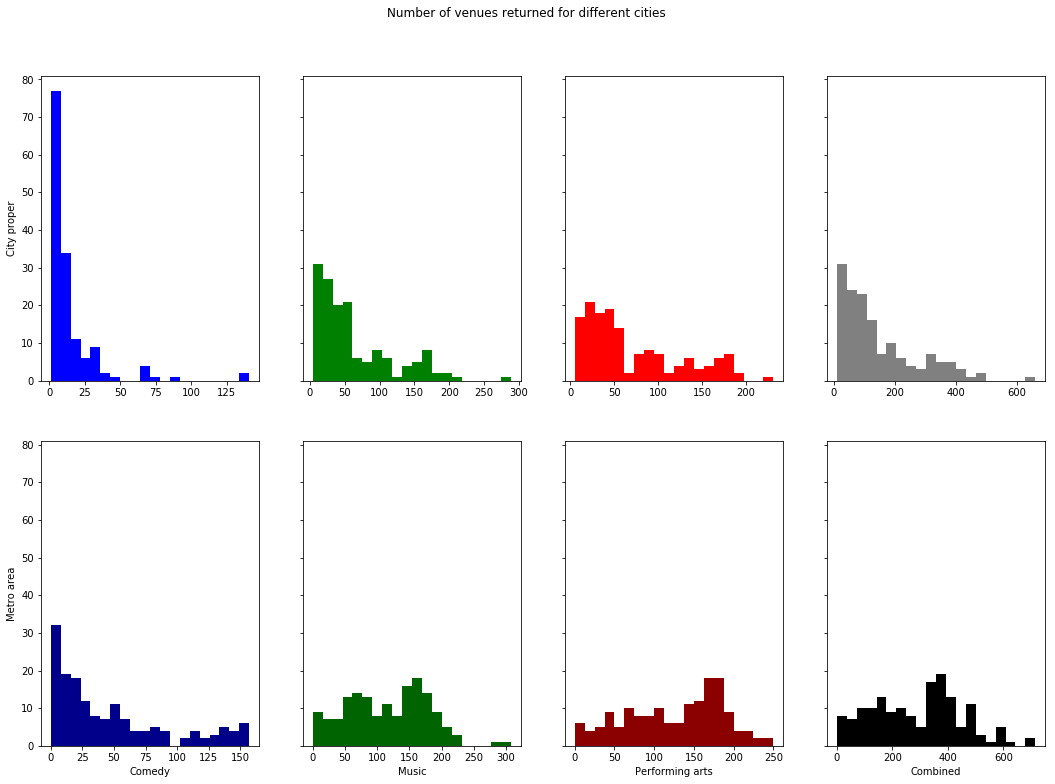

In [538]:
n_bins = 20

fig, ax = plt.subplots(2, 4, sharex=False, sharey=True, tight_layout=False)
ax[0, 0].hist(total_comedy_15km, bins=n_bins, color='blue')
ax[1, 0].hist(total_comedy_100km, bins=n_bins, color='darkblue')
ax[0, 1].hist(total_music_15km, bins=n_bins, color='green')
ax[1, 1].hist(total_music_100km, bins=n_bins, color='darkgreen')
ax[0, 2].hist(total_performing_15km, bins=n_bins, color='red')
ax[1, 2].hist(total_performing_100km, bins=n_bins, color='darkred')
ax[0, 3].hist(total_grand_15km, bins=n_bins, color='gray')
ax[1, 3].hist(total_grand_100km, bins=n_bins, color='black')

ax[1, 0].set_xlabel('Comedy')
ax[1, 1].set_xlabel('Music')
ax[1, 2].set_xlabel('Performing arts')
ax[1, 3].set_xlabel('Combined')

ax[0, 0].set_ylabel('City proper')
ax[1, 0].set_ylabel('Metro area')

plt.suptitle('Number of venues returned for different cities')
plt.subplots_adjust(top=0.9)

plt.show()

### Performances vs. city characteristics
1. Does cost of living, city size, or city population density predict presence of performances of different types?

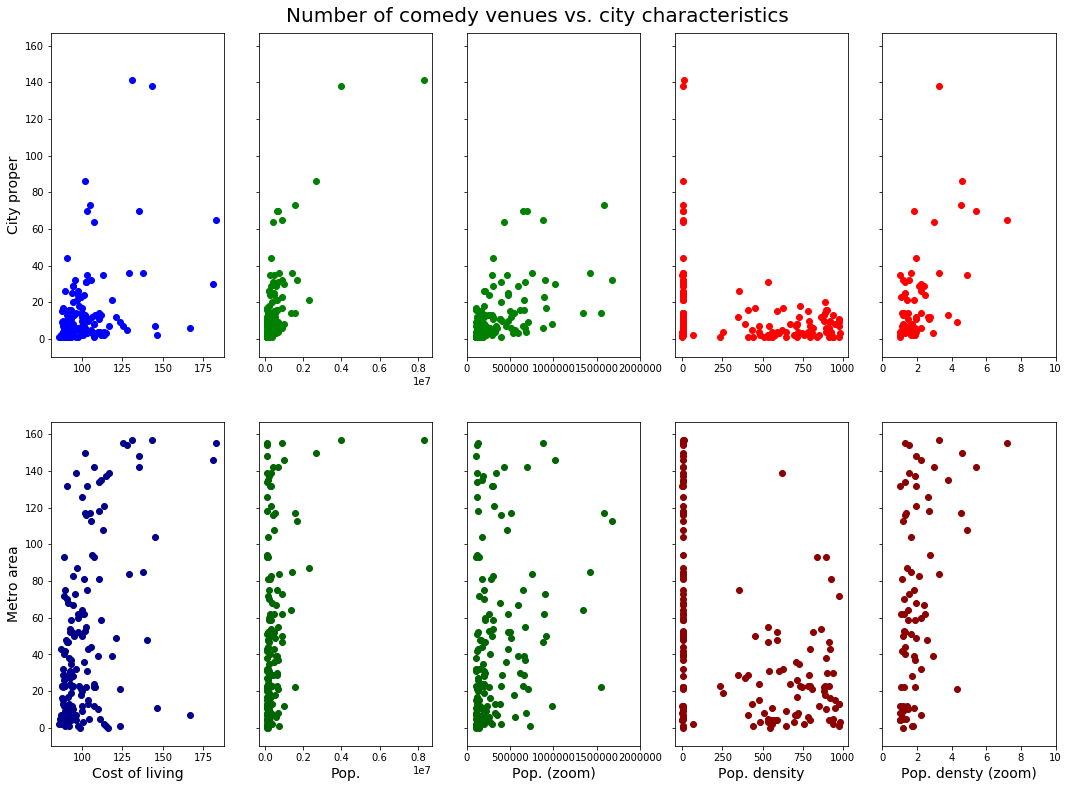

In [552]:
fig, ax = plt.subplots(2, 5, sharex=False, sharey=True, tight_layout=False)
ax[0, 0].scatter(cost_of_living_15km, total_comedy_15km, color='blue')
ax[1, 0].scatter(cost_of_living_100km, total_comedy_100km, color='darkblue')
ax[0, 1].scatter(population_15km, total_comedy_15km, color='green')
ax[1, 1].scatter(population_100km, total_comedy_100km, color='darkgreen')
ax[0, 2].scatter(population_15km, total_comedy_15km, color='green')
ax[1, 2].scatter(population_100km, total_comedy_100km, color='darkgreen')
ax[0, 3].scatter(pop_density_15km, total_comedy_15km, color='red')
ax[1, 3].scatter(pop_density_100km, total_comedy_100km, color='darkred')
ax[0, 4].scatter(pop_density_15km, total_comedy_15km, color='red')
ax[1, 4].scatter(pop_density_100km, total_comedy_100km, color='darkred')

ax[0,2].set_xlim([0, 0.2e7])
ax[1,2].set_xlim([0, 0.2e7])
ax[0,4].set_xlim([0, 10])
ax[1,4].set_xlim([0, 10])

ax[1, 0].set_xlabel('Cost of living', fontsize=14)
ax[1, 1].set_xlabel('Pop.', fontsize=14)
ax[1, 2].set_xlabel('Pop. (zoom)', fontsize=14)
ax[1, 3].set_xlabel('Pop. density', fontsize=14)
ax[1, 4].set_xlabel('Pop. densty (zoom)', fontsize=14)

ax[0, 0].set_ylabel('City proper', fontsize=14)
ax[1, 0].set_ylabel('Metro area', fontsize=14)

plt.suptitle('Number of comedy venues vs. city characteristics', fontsize=20)
plt.subplots_adjust(top=0.95)

plt.show()

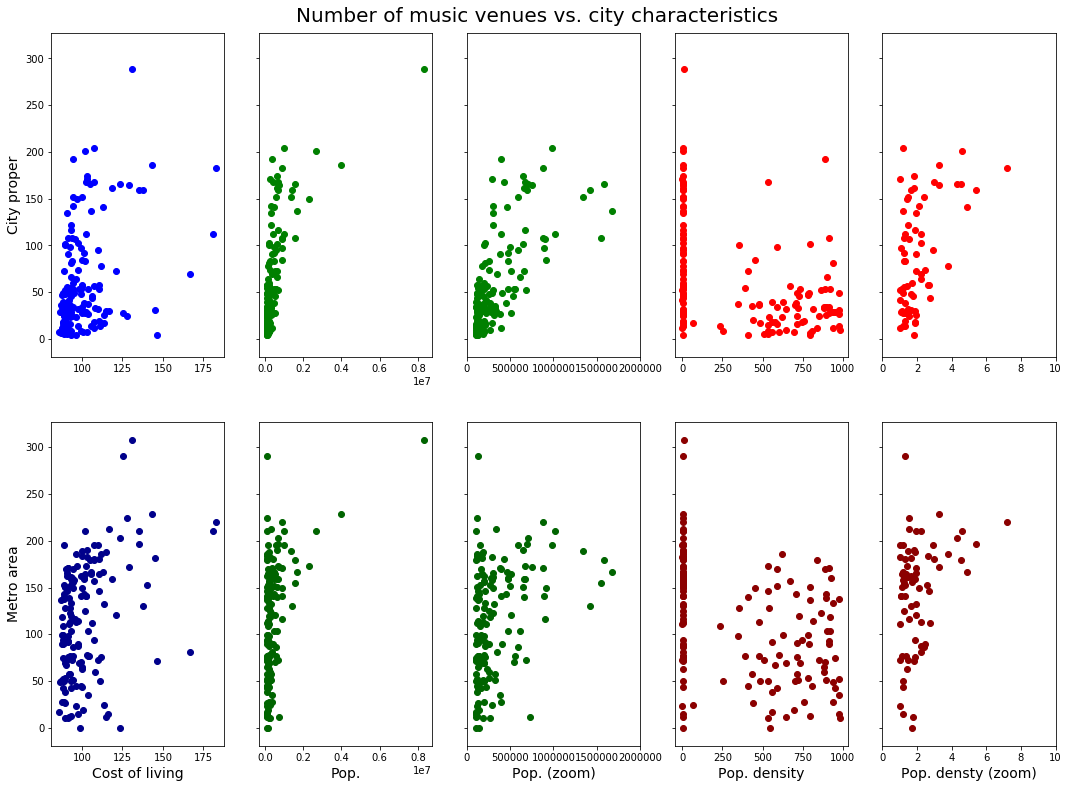

In [553]:
fig, ax = plt.subplots(2, 5, sharex=False, sharey=True, tight_layout=False)
ax[0, 0].scatter(cost_of_living_15km, total_music_15km, color='blue')
ax[1, 0].scatter(cost_of_living_100km, total_music_100km, color='darkblue')
ax[0, 1].scatter(population_15km, total_music_15km, color='green')
ax[1, 1].scatter(population_100km, total_music_100km, color='darkgreen')
ax[0, 2].scatter(population_15km, total_music_15km, color='green')
ax[1, 2].scatter(population_100km, total_music_100km, color='darkgreen')
ax[0, 3].scatter(pop_density_15km, total_music_15km, color='red')
ax[1, 3].scatter(pop_density_100km, total_music_100km, color='darkred')
ax[0, 4].scatter(pop_density_15km, total_music_15km, color='red')
ax[1, 4].scatter(pop_density_100km, total_music_100km, color='darkred')

ax[0,2].set_xlim([0, 0.2e7])
ax[1,2].set_xlim([0, 0.2e7])
ax[0,4].set_xlim([0, 10])
ax[1,4].set_xlim([0, 10])

ax[1, 0].set_xlabel('Cost of living', fontsize=14)
ax[1, 1].set_xlabel('Pop.', fontsize=14)
ax[1, 2].set_xlabel('Pop. (zoom)', fontsize=14)
ax[1, 3].set_xlabel('Pop. density', fontsize=14)
ax[1, 4].set_xlabel('Pop. densty (zoom)', fontsize=14)

ax[0, 0].set_ylabel('City proper', fontsize=14)
ax[1, 0].set_ylabel('Metro area', fontsize=14)

plt.suptitle('Number of music venues vs. city characteristics', fontsize=20)
plt.subplots_adjust(top=0.95)

plt.show()

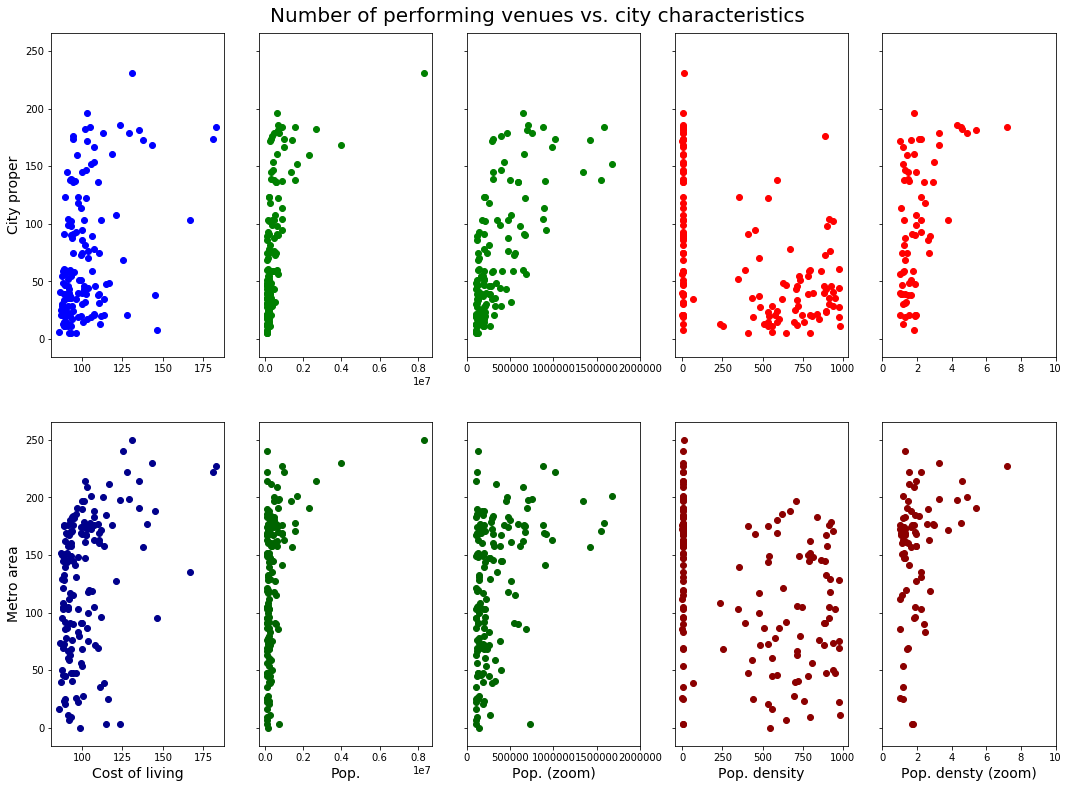

In [554]:
fig, ax = plt.subplots(2, 5, sharex=False, sharey=True, tight_layout=False)
ax[0, 0].scatter(cost_of_living_15km, total_performing_15km, color='blue')
ax[1, 0].scatter(cost_of_living_100km, total_performing_100km, color='darkblue')
ax[0, 1].scatter(population_15km, total_performing_15km, color='green')
ax[1, 1].scatter(population_100km, total_performing_100km, color='darkgreen')
ax[0, 2].scatter(population_15km, total_performing_15km, color='green')
ax[1, 2].scatter(population_100km, total_performing_100km, color='darkgreen')
ax[0, 3].scatter(pop_density_15km, total_performing_15km, color='red')
ax[1, 3].scatter(pop_density_100km, total_performing_100km, color='darkred')
ax[0, 4].scatter(pop_density_15km, total_performing_15km, color='red')
ax[1, 4].scatter(pop_density_100km, total_performing_100km, color='darkred')

ax[0,2].set_xlim([0, 0.2e7])
ax[1,2].set_xlim([0, 0.2e7])
ax[0,4].set_xlim([0, 10])
ax[1,4].set_xlim([0, 10])

ax[1, 0].set_xlabel('Cost of living', fontsize=14)
ax[1, 1].set_xlabel('Pop.', fontsize=14)
ax[1, 2].set_xlabel('Pop. (zoom)', fontsize=14)
ax[1, 3].set_xlabel('Pop. density', fontsize=14)
ax[1, 4].set_xlabel('Pop. densty (zoom)', fontsize=14)

ax[0, 0].set_ylabel('City proper', fontsize=14)
ax[1, 0].set_ylabel('Metro area', fontsize=14)

plt.suptitle('Number of performing venues vs. city characteristics', fontsize=20)
plt.subplots_adjust(top=0.95)

plt.show()

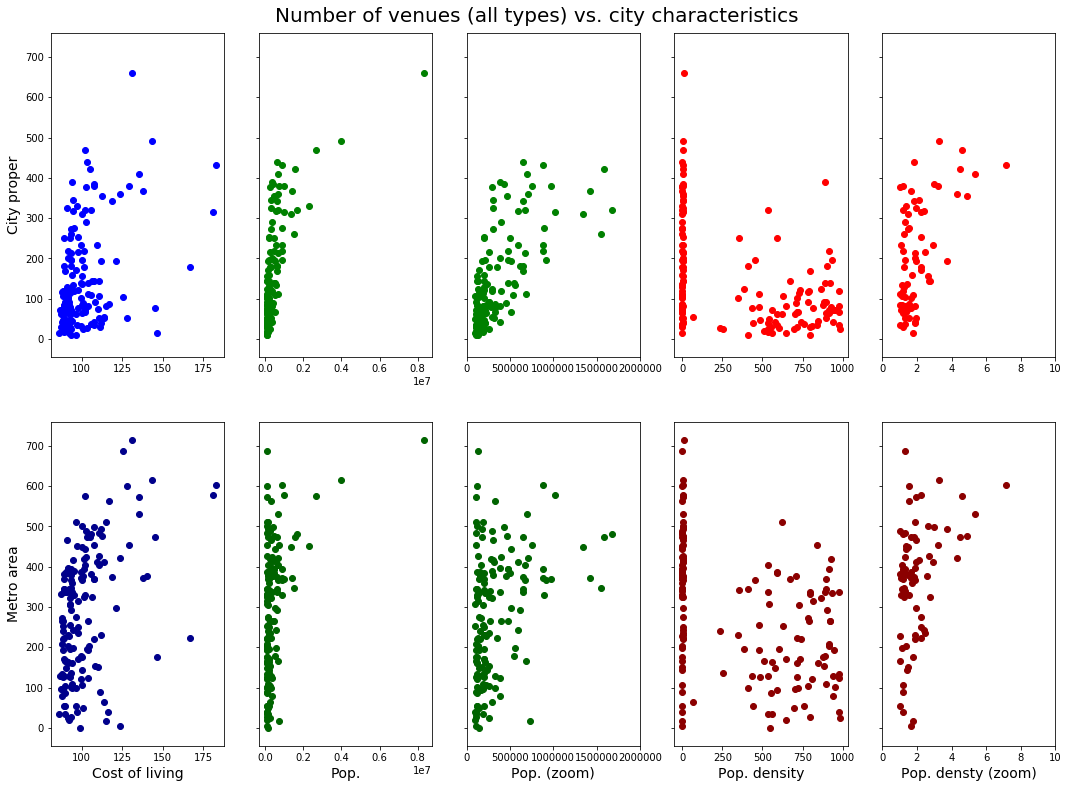

In [556]:
fig, ax = plt.subplots(2, 5, sharex=False, sharey=True, tight_layout=False)
ax[0, 0].scatter(cost_of_living_15km, total_grand_15km, color='blue')
ax[1, 0].scatter(cost_of_living_100km, total_grand_100km, color='darkblue')
ax[0, 1].scatter(population_15km, total_grand_15km, color='green')
ax[1, 1].scatter(population_100km, total_grand_100km, color='darkgreen')
ax[0, 2].scatter(population_15km, total_grand_15km, color='green')
ax[1, 2].scatter(population_100km, total_grand_100km, color='darkgreen')
ax[0, 3].scatter(pop_density_15km, total_grand_15km, color='red')
ax[1, 3].scatter(pop_density_100km, total_grand_100km, color='darkred')
ax[0, 4].scatter(pop_density_15km, total_grand_15km, color='red')
ax[1, 4].scatter(pop_density_100km, total_grand_100km, color='darkred')

ax[0,2].set_xlim([0, 0.2e7])
ax[1,2].set_xlim([0, 0.2e7])
ax[0,4].set_xlim([0, 10])
ax[1,4].set_xlim([0, 10])

ax[1, 0].set_xlabel('Cost of living', fontsize=14)
ax[1, 1].set_xlabel('Pop.', fontsize=14)
ax[1, 2].set_xlabel('Pop. (zoom)', fontsize=14)
ax[1, 3].set_xlabel('Pop. density', fontsize=14)
ax[1, 4].set_xlabel('Pop. densty (zoom)', fontsize=14)

ax[0, 0].set_ylabel('City proper', fontsize=14)
ax[1, 0].set_ylabel('Metro area', fontsize=14)

plt.suptitle('Number of venues (all types) vs. city characteristics', fontsize=20)
plt.subplots_adjust(top=0.95)

plt.show()

### Can city characteristics be used to model performance presence?

In [ ]:
total_comedy_15km = np.array(df_0_15km['total results - comedy'])
total_comedy_100km = np.array(df_0_100km['total results - comedy'])
total_music_15km = np.array(df_0_15km['total results - music'])
total_music_100km = np.array(df_0_100km['total results - music'])
total_performing_15km = np.array(df_0_15km['total results - performing'])
total_performing_100km = np.array(df_0_100km['total results - performing'])
total_grand_15km = total_comedy_15km + total_music_15km + total_performing_15km
total_grand_100km = total_comedy_100km + total_music_100km + total_performing_100km

cost_of_living_15km = np.array(df_0_15km['Cost of Living Index'])
cost_of_living_100km = np.array(df_0_100km['Cost of Living Index'])
population_15km = np.array([int(item) for item in list(df_0_15km['2019 estimate'])])
population_100km = np.array([int(item) for item in list(df_0_100km['2019 estimate'])])
pop_density_15km = np.array(list([float(item[:-4].replace(',', '.')) for item in df_0_15km['2016 population density (km^-2)']]))
pop_density_100km = np.array(list([float(item[:-4].replace(',', '.')) for item in df_0_100km['2016 population density (km^-2)']]))

city_lat_15km  =  1 * np.array([float(item[(item.rindex('/') + 2):(item.index(';'))])    for item in list(df_0_15km['Location'])])
city_lng_15km  = -1 * np.array([float(item[(item.index(';') + 3):(item.index('(') - 2)]) for item in list(df_0_15km['Location'])])
city_lat_100km =  1 * np.array([float(item[(item.rindex('/') + 2):(item.index(';'))])    for item in list(df_0_100km['Location'])])
city_lng_100km = -1 * np.array([float(item[(item.index(';') + 3):(item.index('(') - 2)]) for item in list(df_0_100km['Location'])])

city_name_15km = list(df_0_15km['city'])
state_abbr_15km = list(df_0_15km['state abbreviation'])
city_name_100km = list(df_0_100km['city'])
state_abbr_100km = list(df_0_100km['state abbreviation'])


In [841]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [831]:
X_15km = pd.DataFrame(\
                      np.transpose([cost_of_living_15km, population_15km, pop_density_15km, city_lat_15km, city_lng_15km]),\
                      columns=['cost of living', 'population', 'population density', 'latitude', 'longitude']\
                 )
X_100km = pd.DataFrame(\
                      np.transpose([cost_of_living_100km, population_100km, pop_density_100km, city_lat_100km, city_lng_100km]),\
                      columns=['cost of living', 'population', 'population density', 'latitude', 'longitude']\
                 )

X_15km = preprocessing.StandardScaler().fit(X_15km).transform(X_15km)
X_100km = preprocessing.StandardScaler().fit(X_100km).transform(X_100km)

X_train_comedy_15km, X_test_comedy_15km, total_comedy_15km_train, total_comedy_15km_test = train_test_split(X_15km, total_comedy_15km)
X_train_comedy_100km, X_test_comedy_100km, total_comedy_100km_train, total_comedy_100km_test = train_test_split(X_100km, total_comedy_100km)
X_train_music_15km, X_test_music_15km, total_music_15km_train, total_music_15km_test = train_test_split(X_15km, total_music_15km)
X_train_music_100km, X_test_music_100km, total_music_100km_train, total_music_100km_test = train_test_split(X_100km, total_music_100km)
X_train_performing_15km, X_test_performing_15km, total_performing_15km_train, total_performing_15km_test = train_test_split(X_15km, total_performing_15km)
X_train_performing_100km, X_test_performing_100km, total_performing_100km_train, total_performing_100km_test = train_test_split(X_100km, total_performing_100km)
X_train_grand_15km, X_test_grand_15km, total_grand_15km_train, total_grand_15km_test = train_test_split(X_15km, total_grand_15km)
X_train_grand_100km, X_test_grand_100km, total_grand_100km_train, total_grand_100km_test = train_test_split(X_100km, total_grand_100km)

In [852]:
X_trains = [X_train_comedy_15km, X_train_comedy_100km,\
            X_train_music_15km, X_train_music_100km,\
            X_train_performing_15km, X_train_performing_100km,\
            X_train_grand_15km, X_train_grand_100km]
y_trains = [total_comedy_15km_train, total_comedy_100km_train,\
            total_music_15km_train, total_music_100km_train,\
            total_performing_15km_train, total_performing_100km_train,\
            total_grand_15km_train, total_grand_100km_train]
X_tests = [X_test_comedy_15km, X_test_comedy_100km,\
           X_test_music_15km, X_test_music_100km,\
           X_test_performing_15km, X_test_performing_100km,\
           X_test_grand_15km, X_test_grand_100km]
y_tests = [total_comedy_15km_test, total_comedy_100km_test,\
           total_music_15km_test, total_music_100km_test,\
           total_performing_15km_test, total_performing_100km_test,\
           total_grand_15km_test, total_grand_100km_test]
names = ['comedy 15km', 'comedy 100km',\
           'music 15km', 'music 100km',\
           'performing 15km', 'performing 100km',\
           'grand 15km', 'grand 100km']

C_values     = np.array([1e-4, 1e-3, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0, 2.5, 5.0])
alpha_values = 1.0 / (2.0 * C_values)

for i in range(len(names)):
    
    X_train = X_trains[i]
    y_train = y_trains[i].astype(float)
    X_test  = X_tests[i]
    y_test  = y_tests[i].astype(float)
    name    = names[i]
    
    accuracy_values = [0 for item in range(len(C_values))]
    for j in range(len(C_values)):
        clf = Ridge(alpha=alpha_values[j])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # accuracy_values[j] = metrics.accuracy_score(y_test, y_pred) # accuracy_score for classification, not regression
        accuracy_values[j] = metrics.r2_score(y_test, y_pred)

    print(name + ', alpha, r2 best: ' + str(alpha_values[np.argmax(accuracy_values)]) + ', ' + str(np.max(accuracy_values)))

comedy 15km, alpha, r2 best: 50.0, 0.0548142955012
comedy 100km, alpha, r2 best: 0.1, 0.135746762099
music 15km, alpha, r2 best: 0.1, 0.41259005635
music 100km, alpha, r2 best: 50.0, 0.15782372269
performing 15km, alpha, r2 best: 50.0, 0.45157866903
performing 100km, alpha, r2 best: 0.1, 0.276817748342
grand 15km, alpha, r2 best: 0.1, 0.2896320861
grand 100km, alpha, r2 best: 0.1, 0.56441369898


In [557]:
df_0_15km.head()

2019 rank           city       state state abbreviation  \
0          1  New York City    New York                 NY   
1          2    Los Angeles  California                 CA   
2          3        Chicago    Illinois                 IL   
3          4        Houston       Texas                 TX   
4          5        Phoenix     Arizona                 AZ   

   Cost of Living Index 2019 estimate 2010 census   change  \
0                 131.0       8336817     8175133   +1.98%   
1                 143.4       3979576     3792621   +4.93%   
2                 102.0       2693976     2695598   −0.06%   
3                  96.9       2320268     2100263  +10.48%   
4                 105.8       1680992     1445632  +16.28%   

  2016 land area (mi^2) 2016 land area (km^2) 2016 population density (mi^-2)  \
0           301.5 sq mi             780.9 km2                    28,317/sq mi   
1           468.7 sq mi           1,213.9 km2                     8,484/sq mi   
2           227.3 sq mi             588.7 km2                    11,900/sq mi   
3           637.5 sq mi           1,651.1 km2                     3,613/sq mi   
4           517.6 sq mi           1,340.6 km2                     3,120/sq mi   

  2016 population density (km^-2)  \
0                      10,933/km2   
1                       3,276/km2   
2                       4,600/km2   
3                       1,395/km2   
4                       1,200/km2   

                                            Location  total results - comedy  \
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...                     141   
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...                     138   
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...                      86   
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...                      21   
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...                      32   

   total results - music  total results - performing  
0                    289                         231  
1                    186                         168  
2                    201                         182  
3                    150                         160  
4                    137                         152

In [767]:
us_lat = 39.8283; us_lon = -98.5795
map_1_15km_comedy     = folium.Map(location=[us_lat, us_lon], zoom_start=4)
map_1_15km_music      = folium.Map(location=[us_lat, us_lon], zoom_start=4)
map_1_15km_performing = folium.Map(location=[us_lat, us_lon], zoom_start=4)
map_1_15km_grand      = folium.Map(location=[us_lat, us_lon], zoom_start=4)

cost_of_living_norm_15km = cost_of_living_15km
cost_of_living_norm_15km = cost_of_living_norm_15km - np.min(cost_of_living_norm_15km)
cost_of_living_norm_15km = cost_of_living_norm_15km / np.max(cost_of_living_norm_15km)
cost_of_living_colors_15km = cm.jet(cost_of_living_norm_15km)
cost_of_living_colors_15km = [colors.to_hex(item[0:3]) for item in list(cost_of_living_colors_15km)]

city_name_15km = list(df_0_15km['city'])
state_abbr_15km = list(df_0_15km['state abbreviation'])
city_name_100km = list(df_0_100km['city'])
state_abbr_100km = list(df_0_100km['state abbreviation'])

for i in range(len(df_0_15km)):
    
    label = city_name_15km[i] + ', ' + state_abbr_15km[i]
    
    lat = city_lat_15km[i]
    lng = city_lng_15km[i]
    rad_comedy     = np.sqrt(total_comedy_15km[i])
    rad_music      = np.sqrt(total_music_15km[i])
    rad_performing = np.sqrt(total_performing_15km[i])
    rad_grand      = np.sqrt(total_comedy_15km[i] + total_music_15km[i] + total_performing_15km[i])
    folium.CircleMarker([lat, lng], radius=rad_comedy,     color=cost_of_living_colors_15km[i], popup=label, fill=True, fill_opacity=0.2).add_to(map_1_15km_comedy)
    folium.CircleMarker([lat, lng], radius=rad_music,      color=cost_of_living_colors_15km[i], popup=label, fill=True, fill_opacity=0.2).add_to(map_1_15km_music)
    folium.CircleMarker([lat, lng], radius=rad_performing, color=cost_of_living_colors_15km[i], popup=label, fill=True, fill_opacity = 0.2).add_to(map_1_15km_performing)
    folium.CircleMarker([lat, lng], radius=rad_grand,      color=cost_of_living_colors_15km[i], popup=label, fill=True, fill_opacity = 0.2).add_to(map_1_15km_grand)

# This shit's not working so I won't worry about it
# colormap_15km = branca.colormap.linear.Reds_01.scale(np.min(cost_of_living_15km), np.max(cost_of_living_15km))
# colormap_15km = branca.colormap.LinearColormap(['#fff5f0', '#67000d'])
# colormap_15km.caption = 'Cost of living index'
# colormap_15km.add_to(map_1_15km_comedy)
# colormap_15km.add_to(map_1_15km_music)
# colormap_15km.add_to(map_1_15km_performing)

In [768]:
map_1_15km_comedy

In [769]:
map_1_15km_music

In [770]:
map_1_15km_performing

In [771]:
map_1_15km_grand

In [772]:
us_lat = 39.8283; us_lon = -98.5795
map_1_100km_comedy     = folium.Map(location=[us_lat, us_lon], zoom_start=4)
map_1_100km_music      = folium.Map(location=[us_lat, us_lon], zoom_start=4)
map_1_100km_performing = folium.Map(location=[us_lat, us_lon], zoom_start=4)
map_1_100km_grand      = folium.Map(location=[us_lat, us_lon], zoom_start=4)

cost_of_living_norm_100km = cost_of_living_100km
cost_of_living_norm_100km = cost_of_living_norm_100km - np.min(cost_of_living_norm_100km)
cost_of_living_norm_100km = cost_of_living_norm_100km / np.max(cost_of_living_norm_100km)
cost_of_living_colors_100km = cm.jet(cost_of_living_norm_100km)
cost_of_living_colors_100km = [colors.to_hex(item[0:3]) for item in list(cost_of_living_colors_100km)]

city_name_100km = list(df_0_100km['city'])
state_abbr_100km = list(df_0_100km['state abbreviation'])
city_name_100km = list(df_0_100km['city'])
state_abbr_100km = list(df_0_100km['state abbreviation'])

for i in range(len(df_0_100km)):
    
    label = city_name_100km[i] + ', ' + state_abbr_100km[i]
    
    lat = city_lat_100km[i]
    lng = city_lng_100km[i]
    rad_comedy     = np.sqrt(total_comedy_100km[i])
    rad_music      = np.sqrt(total_music_100km[i])
    rad_performing = np.sqrt(total_performing_100km[i])
    rad_grand      = np.sqrt(total_comedy_100km[i] + total_music_100km[i] + total_performing_100km[i])
    folium.CircleMarker([lat, lng], radius=rad_comedy,     color=cost_of_living_colors_100km[i], popup=label, fill=True, fill_opacity=0.2).add_to(map_1_100km_comedy)
    folium.CircleMarker([lat, lng], radius=rad_music,      color=cost_of_living_colors_100km[i], popup=label, fill=True, fill_opacity=0.2).add_to(map_1_100km_music)
    folium.CircleMarker([lat, lng], radius=rad_performing, color=cost_of_living_colors_100km[i], popup=label, fill=True, fill_opacity = 0.2).add_to(map_1_100km_performing)
    folium.CircleMarker([lat, lng], radius=rad_grand,      color=cost_of_living_colors_100km[i], popup=label, fill=True, fill_opacity = 0.2).add_to(map_1_100km_grand)

# This shit's not working so I won't worry about it
# colormap_100km = branca.colormap.linear.Reds_01.scale(np.min(cost_of_living_100km), np.max(cost_of_living_100km))
# colormap_100km = branca.colormap.LinearColormap(['#fff5f0', '#67000d'])
# colormap_100km.caption = 'Cost of living index'
# colormap_100km.add_to(map_1_100km_comedy)
# colormap_100km.add_to(map_1_100km_music)
# colormap_100km.add_to(map_1_100km_performing)

In [773]:
map_1_100km_comedy

In [774]:
map_1_100km_music

In [775]:
map_1_100km_performing

In [776]:
map_1_100km_grand

In [818]:
us_lat = 39.8283; us_lon = -98.5795
map_1_15km_all = folium.Map(location=[us_lat, us_lon], zoom_start=4)

j_limit = 5 # to avoid crashing with too much data
for i in range(len(df_0_15km)):
    
    label = city_name_15km[i] + ', ' + state_abbr_15km[i]
    rad = 5
    
    for j in range(np.min([j_limit, len(lat_lon_comedy_15km[i])])):#range(len(lat_lon_comedy_15km[i])):
        lat = lat_lon_comedy_15km[i][j][0]
        lng = lat_lon_comedy_15km[i][j][1]
        folium.CircleMarker([lat, lng], radius=rad, color='blue', popup=label, fill=True, fill_opacity=0.2).add_to(map_1_15km_all)
    for j in range(np.min([j_limit, len(lat_lon_music_15km[i])])):#range(len(lat_lon_music_15km[i])):
        lat = lat_lon_music_15km[i][j][0]
        lng = lat_lon_music_15km[i][j][1]
        folium.CircleMarker([lat, lng], radius=rad, color='green', popup=label, fill=True, fill_opacity=0.2).add_to(map_1_15km_all)
    for j in range(np.min([j_limit, len(lat_lon_performing_15km[i])])):#range(len(lat_lon_performing_15km[i])):
        lat = lat_lon_performing_15km[i][j][0]
        lng = lat_lon_performing_15km[i][j][1]
        folium.CircleMarker([lat, lng], radius=rad, color='red', popup=label, fill=True, fill_opacity=0.2).add_to(map_1_15km_all)
    

In [819]:
map_1_15km_all

# Experimenting: Define location, radius, and search url
Not actually used in this analysis, this was just the playing around I did to figure out how to do things.

In [61]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="foursquare_agent")
location   = geolocator.geocode(address)
latitude   = location.latitude
longitude  = location.longitude
print(latitude, longitude)

# search_query = 'Italian'
search_query = 'Music Venue'
category_id  = '4bf58dd8d48988d1e5931735' # https://developer.foursquare.com/docs/build-with-foursquare/categories/ , music venues
category_id  = '4d4b7104d754a06370d81259' # arts and entertainment
radius       = 100000
LIMIT        = 50

# url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&limit={}'\
# .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, LIMIT)

# url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&limit={}'\
# .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_id, LIMIT)

# offset = 0
# url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&limit={}&offset={}'\
# .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_id, LIMIT, offset)

offset = 0
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&offset={}'\
.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_id, radius, LIMIT, offset)


print(url)

47.6038321 -122.3300624
https://api.foursquare.com/v2/venues/explore?client_id=FEKX35VA2NPKQUASN04CUPKIJHDKOE0Y5BZO2SFRLX24N22S&client_secret=BYY5BWEJ45S4ZYZNCO5HTVWU2W2S5GJEOKID2JVW1HQ01RQ3&ll=47.6038321,-122.3300624&v=20180604&categoryId=4d4b7104d754a06370d81259&radius=100000&limit=50&offset=0


## Send get request using above URL

In [62]:
results = requests.get(url).json()
# results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df = json_normalize(venues)
df.head()

KeyError: 'venues'

In [63]:
results

{'meta': {'code': 200, 'requestId': '5fbe8c25eebe982143225381'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4276bf00f964a52083211fe3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d17f941735',
         'name': 'Movie Theater',
         'pluralName': 'Movie Theaters',
         'primary': True,
         'shortName': 'Movie Theater'}],
       'id': '4276bf00f964a52083211fe3',
       'location': {'address': '2100 4th Ave',
        'cc': 'US',
        'city': 'Seattle',
        'country': 'United States',
        'crossStreet': 'at Lenora St',
        'distance': 1431,
        'formattedAddress': ['2100 4th Ave (at Lenora St)',
         'Seattle, WA 98121',
         'United Sta

In [26]:
len(df)

50

In [38]:
df1.head()

categories delivery.id  \
0  [{'primary': True, 'name': 'Music Venue', 'id'...     1572599   
1  [{'primary': True, 'name': 'Music Venue', 'id'...         NaN   
2  [{'primary': True, 'name': 'Other Great Outdoo...         NaN   
3  [{'primary': True, 'name': 'Music Venue', 'id'...         NaN   
4  [{'primary': True, 'name': 'General College & ...         NaN   

               delivery.provider.icon.name  \
0  /delivery_provider_grubhub_20180129.png   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

              delivery.provider.icon.prefix delivery.provider.icon.sizes  \
0  https://fastly.4sqi.net/img/general/cap/                     [40, 50]   
1                                       NaN                          NaN   
2                                       NaN                          NaN   
3                                       NaN                          NaN   
4                                       NaN                          NaN   

  delivery.provider.name                                       delivery.url  \
0                grubhub  https://www.grubhub.com/restaurant/triple-door...   
1                    NaN                                                NaN   
2                    NaN                                                NaN   
3                    NaN                                                NaN   
4                    NaN                                                NaN   

   hasPerk                        id location.address     ...       \
0    False  40b68100f964a5206e001fe3     216 Union St     ...        
1    False  52d7e957498ebb6fa54b4ccd              NaN     ...        
2    False  5aef9b105455b2002c440f8b              NaN     ...        
3    False  51a289c3498e6d1b9190830c              NaN     ...        
4    False  4b1a9e16f964a52089ed23e3    901 N 96th St     ...        

                           location.formattedAddress  \
0  [216 Union St (at 2nd Ave), Seattle, WA 98101,...   
1                      [Bellevue, WA, United States]   
2  [187th Place NE, Redmond, WA 98074, United Sta...   
3                       [Edmonds, WA, United States]   
4  [901 N 96th St (Linden Ave N), Seattle, WA 981...   

                             location.labeledLatLngs location.lat  \
0  [{'lng': -122.33738987451225, 'lat': 47.608774...    47.608775   
1  [{'lng': -122.1118233034273, 'lat': 47.5851233...    47.585123   
2  [{'lng': -122.090272, 'lat': 47.654234, 'label...    47.654234   
3  [{'lng': -122.34443161434626, 'lat': 47.817613...    47.817613   
4  [{'lng': -122.34707900000001, 'lat': 47.698463...    47.698463   

  location.lng  location.neighborhood location.postalCode location.state  \
0  -122.337390                    NaN               98101             WA   
1  -122.111823                    NaN                 NaN             WA   
2  -122.090272                    NaN               98074             WA   
3  -122.344432                    NaN                 NaN             WA   
4  -122.347079                    NaN               98103             WA   

                                   name    referralId venuePage.id  
0                           Triple Door  v-1606321702          NaN  
1  Howlin' Wolf :: Smokestack Lightnin'  v-1606321702          NaN  
2                 Adelaide Outdoor Area  v-1606321702          NaN  
3                      The Music Studio  v-1606321702          NaN  
4         Music Center of the Northwest  v-1606321702          NaN  

[5 rows x 25 columns]

## Get list
https://developer.foursquare.com/docs/api-reference/lists/details/

In [39]:
GET https://api.foursquare.com/v2/lists/LIST_ID

SyntaxError: invalid syntax (<ipython-input-39-a9df8efd1c38>, line 1)

In [ ]:
url = 'https://api.foursquare.com/v2/lists/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&limit={}&offset={}'\
.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_id, LIMIT, offset)